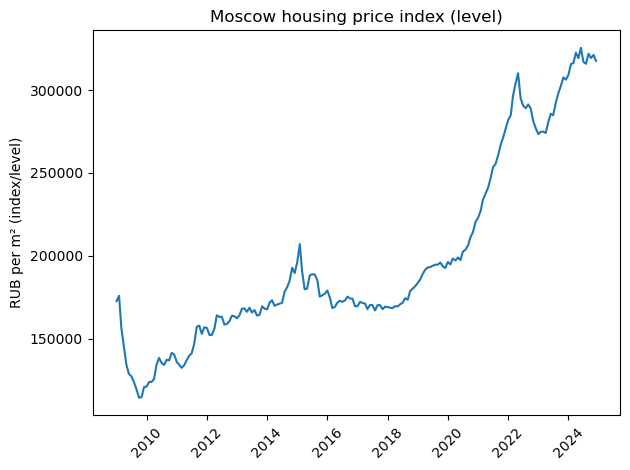

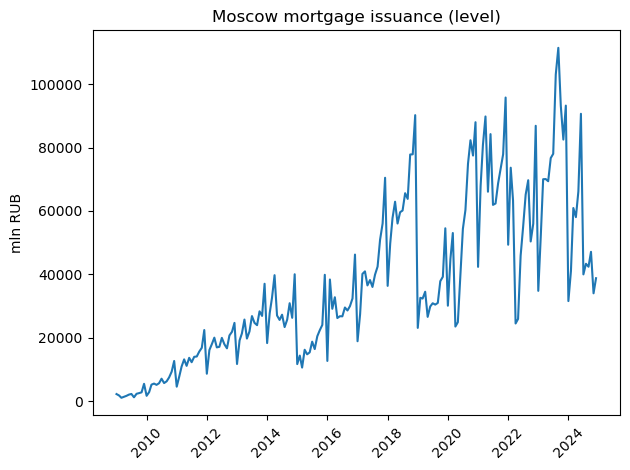

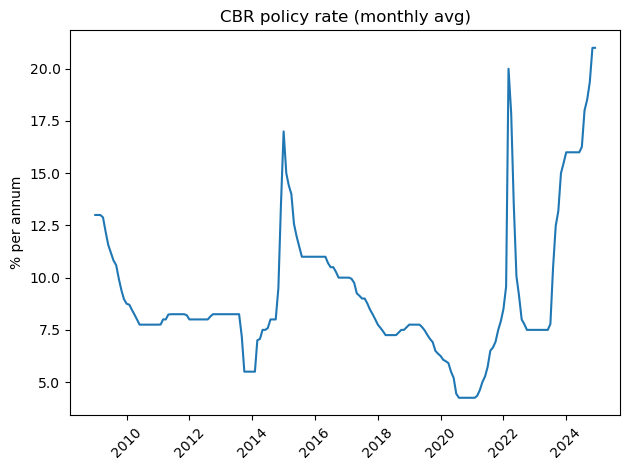

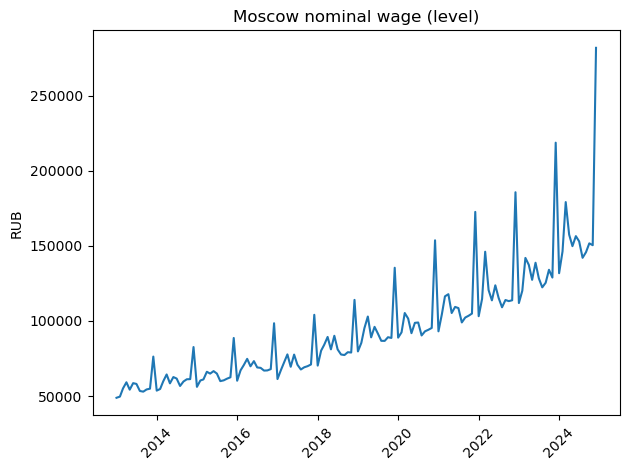

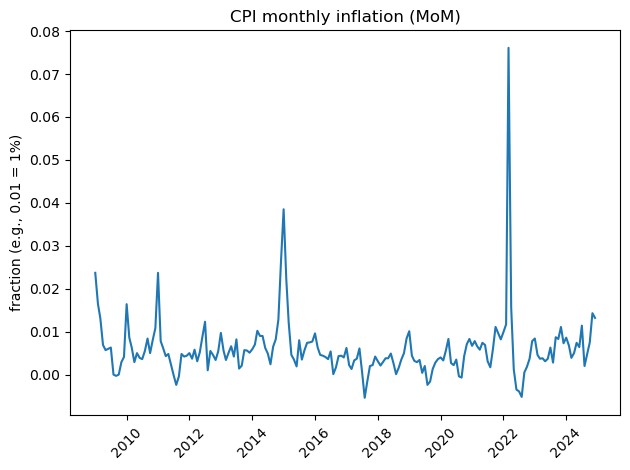

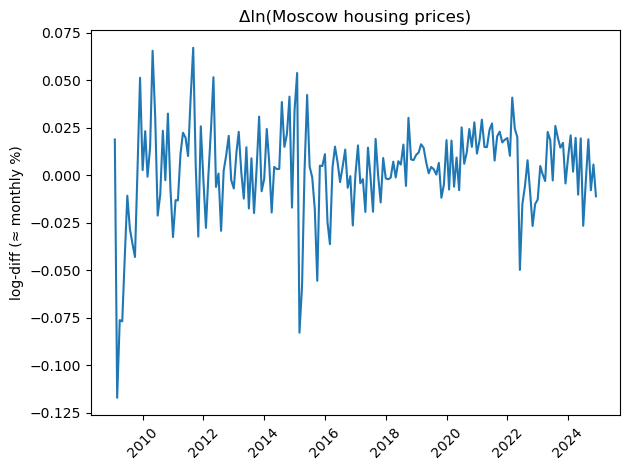

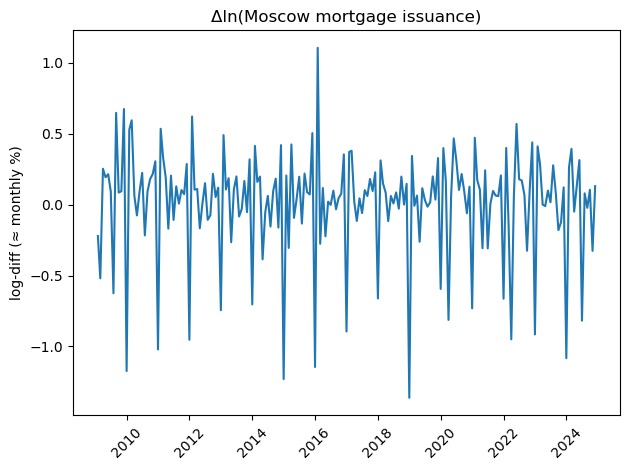

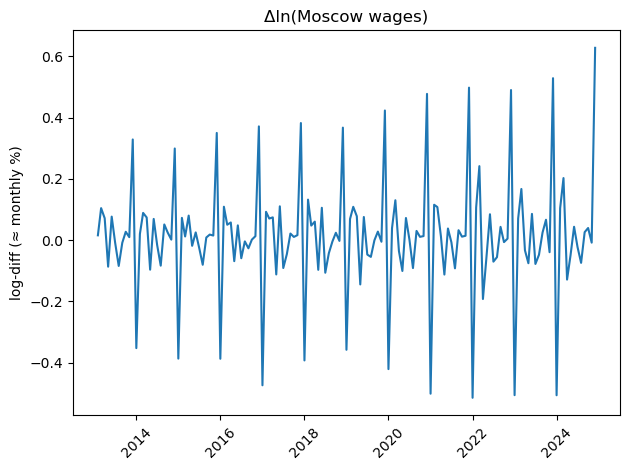


--- Stationarity: LEVELS (logs) ---
ADF  ln(price): stat=0.073, p=0.9642 (H0: unit root / non-stationary)
KPSS ln(price): stat=1.702, p=0.0100 (H0: stationary)
ADF  ln(mortgage): stat=-2.680, p=0.0776 (H0: unit root / non-stationary)
KPSS ln(mortgage): stat=1.564, p=0.0100 (H0: stationary)
ADF  ln(wage): stat=1.950, p=0.9986 (H0: unit root / non-stationary)


/var/folders/6c/zkzm4zcn3q59shm2wx0g0m340000gn/T/ipykernel_24278/1929645973.py:106: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, pval, *_ = kpss(s, regression="c", nlags="auto")
/var/folders/6c/zkzm4zcn3q59shm2wx0g0m340000gn/T/ipykernel_24278/1929645973.py:106: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, pval, *_ = kpss(s, regression="c", nlags="auto")


In [61]:
import pandas as pd
import numpy as np
import re
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox


# LOAD DATA
PATH = "ИЖК_Цены_Ставка_Зарплата_CPI_2009-2024_горизонтально.xlsx"  
SHEET = "horizontal"

raw = pd.read_excel(PATH, sheet_name=SHEET, header=None)

def find_row(label: str) -> int:
    col0 = raw.iloc[:, 0].astype(str).str.strip()
    idx = col0[col0 == label].index
    if len(idx) == 0:
        idx = col0[col0.str.contains(re.escape(label), case=False, na=False)].index
    if len(idx) == 0:
        raise ValueError(f"Row '{label}' not found in column A.")
    return int(idx[0])

# dates in header row 0
date_keys = raw.iloc[0, 1:].astype(str).tolist()
dates = pd.to_datetime(date_keys, format="%Y-%m", errors="coerce")
if dates.isna().any():
    bad = [date_keys[i] for i, d in enumerate(dates) if pd.isna(d)]
    raise ValueError(f"Could not parse some dates: {bad[:10]}")

# main variables
price = pd.to_numeric(raw.iloc[find_row("price_rub_m2"), 1:], errors="coerce").to_numpy()
mort  = pd.to_numeric(raw.iloc[find_row("moscow_flow_mn_rub"), 1:], errors="coerce").to_numpy()
rate  = pd.to_numeric(raw.iloc[find_row("policy_rate_monthly_avg_pct"), 1:], errors="coerce").to_numpy()
wage  = pd.to_numeric(raw.iloc[find_row("wage_nominal_rub_moscow"), 1:], errors="coerce").to_numpy()

# CPI row may or may not be present in this file
cpi = None
try:
    cpi = pd.to_numeric(raw.iloc[find_row("cpi_mom_index_pct"), 1:], errors="coerce").to_numpy()
except:
    pass

df = pd.DataFrame({
    "date": dates,
    "price_rub_m2": price,
    "mortgage_mn_rub": mort,
    "policy_rate_avg_pct": rate,
    "wage_moscow_rub": wage,
}).sort_values("date").reset_index(drop=True)

if cpi is not None:
    df["cpi_mom_index_pct"] = cpi
    df["infl_mom"] = df["cpi_mom_index_pct"]/100 - 1

# log levels + growth rates
df["ln_price"] = np.log(df["price_rub_m2"])
df["ln_mortgage"] = np.log(df["mortgage_mn_rub"])
df["ln_wage"] = np.log(df["wage_moscow_rub"])

df["dln_price"] = df["ln_price"].diff()
df["dln_mortgage"] = df["ln_mortgage"].diff()
df["dln_wage"] = df["ln_wage"].diff()

# PLOTS 
def plot_series(x, y, title, ylabel):
    plt.figure()
    plt.plot(x, y)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Levels
plot_series(df["date"], df["price_rub_m2"], "Moscow housing price index (level)", "RUB per m² (index/level)")
plot_series(df["date"], df["mortgage_mn_rub"], "Moscow mortgage issuance (level)", "mln RUB")
plot_series(df["date"], df["policy_rate_avg_pct"], "CBR policy rate (monthly avg)", "% per annum")
plot_series(df["date"], df["wage_moscow_rub"], "Moscow nominal wage (level)", "RUB")

if "infl_mom" in df.columns:
    plot_series(df["date"], df["infl_mom"], "CPI monthly inflation (MoM)", "fraction (e.g., 0.01 = 1%)")

# Growth rates (log differences)
plot_series(df["date"], df["dln_price"], "Δln(Moscow housing prices)", "log-diff (≈ monthly %)")
plot_series(df["date"], df["dln_mortgage"], "Δln(Moscow mortgage issuance)", "log-diff (≈ monthly %)")
plot_series(df["date"], df["dln_wage"], "Δln(Moscow wages)", "log-diff (≈ monthly %)")

# STATIONARITY TESTS (ADF + KPSS)
def adf_test(series, name):
    s = series.dropna()
    stat, pval, *_ = adfuller(s, autolag="AIC")
    print(f"ADF  {name}: stat={stat:.3f}, p={pval:.4f} (H0: unit root / non-stationary)")

def kpss_test(series, name):
    s = series.dropna()
    stat, pval, *_ = kpss(s, regression="c", nlags="auto")
    print(f"KPSS {name}: stat={stat:.3f}, p={pval:.4f} (H0: stationary)")

print("\n--- Stationarity: LEVELS (logs) ---")
adf_test(df["ln_price"], "ln(price)")
kpss_test(df["ln_price"], "ln(price)")

adf_test(df["ln_mortgage"], "ln(mortgage)")
kpss_test(df["ln_mortgage"], "ln(mortgage)")

adf_test(df["ln_wage"], "ln(wage)")

In [65]:
raw = pd.read_excel(PATH, sheet_name=SHEET, header=None)

def find_row(label: str) -> int:
    col0 = raw.iloc[:, 0].astype(str).str.strip()
    idx = col0[col0 == label].index
    if len(idx) == 0:
        idx = col0[col0.str.contains(re.escape(label), case=False, na=False)].index
    if len(idx) == 0:
        raise ValueError(f"Row '{label}' not found in column A.")
    return int(idx[0])

date_keys = raw.iloc[0, 1:].astype(str).tolist()
dates = pd.to_datetime(date_keys, format="%Y-%m", errors="coerce")

price = pd.to_numeric(raw.iloc[find_row("price_rub_m2"), 1:], errors="coerce").to_numpy()
mort  = pd.to_numeric(raw.iloc[find_row("moscow_flow_mn_rub"), 1:], errors="coerce").to_numpy()
wage  = pd.to_numeric(raw.iloc[find_row("wage_nominal_rub_moscow"), 1:], errors="coerce").to_numpy()

df = pd.DataFrame({"date": dates, "price": price, "mort": mort, "wage": wage}).sort_values("date")

# LOGS + LOG-DIFFERENCES 
df["ln_price"] = np.log(df["price"])
df["ln_mort"]  = np.log(df["mort"])
df["ln_wage"]  = np.log(df["wage"])

df["dln_price"] = df["ln_price"].diff()
df["dln_mort"]  = df["ln_mort"].diff()
df["dln_wage"]  = df["ln_wage"].diff()

# Tests
def adf_test(x, name):
    x = x.dropna()
    stat, pval, _, _, crit, _ = adfuller(x, autolag="AIC")
    print(f"ADF  {name}: stat={stat:.3f}, p={pval:.4f} (H0: unit root / non-stationary)")
    return stat, pval

def kpss_test(x, name):
    x = x.dropna()
    stat, pval, _, crit = kpss(x, regression="c", nlags="auto")
    # if you see InterpolationWarning, it just means p-value is smaller than the printed minimum.
    print(f"KPSS {name}: stat={stat:.3f}, p={pval:.4f} (H0: stationary)")
    return stat, pval

print("\n=== Stationarity tests for LOG-DIFFERENCES (Δln) ===")
adf_test(df["dln_price"], "Δln(price)")
kpss_test(df["dln_price"], "Δln(price)")

adf_test(df["dln_mort"], "Δln(mortgage)")
kpss_test(df["dln_mort"], "Δln(mortgage)")

adf_test(df["dln_wage"], "Δln(wage)")
kpss_test(df["dln_wage"], "Δln(wage)")


=== Stationarity tests for LOG-DIFFERENCES (Δln) ===
ADF  Δln(price): stat=-8.809, p=0.0000 (H0: unit root / non-stationary)
KPSS Δln(price): stat=0.286, p=0.1000 (H0: stationary)
ADF  Δln(mortgage): stat=-3.215, p=0.0191 (H0: unit root / non-stationary)
KPSS Δln(mortgage): stat=0.339, p=0.1000 (H0: stationary)
ADF  Δln(wage): stat=-2.511, p=0.1129 (H0: unit root / non-stationary)
KPSS Δln(wage): stat=0.167, p=0.1000 (H0: stationary)


/var/folders/6c/zkzm4zcn3q59shm2wx0g0m340000gn/T/ipykernel_24278/1895708692.py:39: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, _, crit = kpss(x, regression="c", nlags="auto")
/var/folders/6c/zkzm4zcn3q59shm2wx0g0m340000gn/T/ipykernel_24278/1895708692.py:39: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, _, crit = kpss(x, regression="c", nlags="auto")
/var/folders/6c/zkzm4zcn3q59shm2wx0g0m340000gn/T/ipykernel_24278/1895708692.py:39: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, _, crit = kpss(x, regression="c", nlags="auto")


(0.16674316027973343, 0.1)

Sample: 2009-02-01 to 2024-12-01 | N = 191


<Figure size 640x480 with 0 Axes>

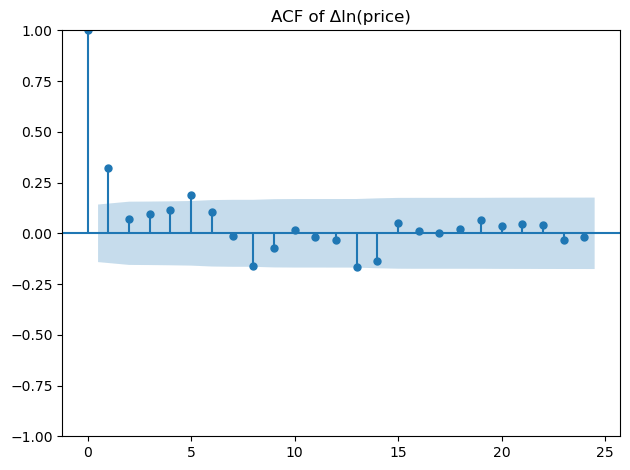

<Figure size 640x480 with 0 Axes>

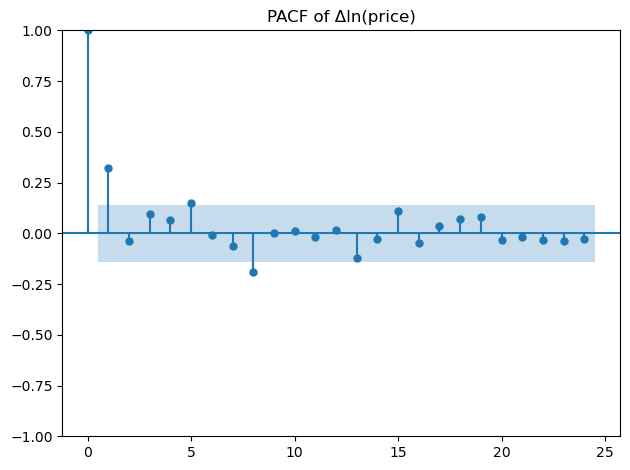

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be use

Best ARMA by AIC: p=0, q=1, AIC=-769.70
                               SARIMAX Results                                
Dep. Variable:              dln_price   No. Observations:                  167
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 386.848
Date:                Tue, 24 Feb 2026   AIC                           -769.696
Time:                        09:46:37   BIC                           -763.460
Sample:                    02-01-2009   HQIC                          -767.165
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3836      0.073      5.224      0.000       0.240       0.527
sigma2         0.0006   3.42e-05     16.613      0.000       0.001       0.001
Ljung-Box (L

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


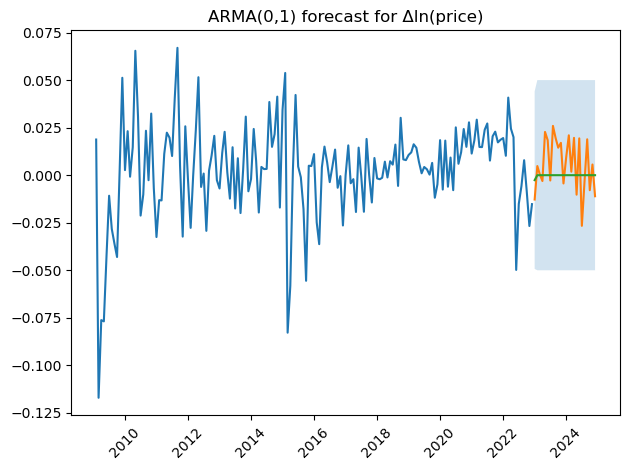

Test RMSE (Δln): 0.014818425440159433


In [67]:
date_keys = raw.iloc[0, 1:].astype(str).tolist()
dates = pd.to_datetime(date_keys, format="%Y-%m", errors="coerce")

# Price series row
price = pd.to_numeric(raw.iloc[find_row("price_rub_m2"), 1:], errors="coerce").to_numpy()

df = pd.DataFrame({"date": dates, "price": price}).dropna().sort_values("date").reset_index(drop=True)

# Build stationary series: dln_price
df["ln_price"] = np.log(df["price"])
df["dln_price"] = df["ln_price"].diff()
ts = df.set_index("date")["dln_price"].dropna()

print("Sample:", ts.index.min().date(), "to", ts.index.max().date(), "| N =", len(ts))

# ACF/PACF plots 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
plot_acf(ts, lags=24)
plt.title("ACF of Δln(price)")
plt.tight_layout()
plt.show()

plt.figure()
plot_pacf(ts, lags=24, method="ywm")
plt.title("PACF of Δln(price)")
plt.tight_layout()
plt.show()

# Traint split 
# last 24 months as test
h = 24
train = ts.iloc[:-h]
test  = ts.iloc[-h:]

# Grid search ARMA(p,q) by AIC
# (ARMA = ARIMA(p,0,q) in statsmodels)
best = {"aic": np.inf, "p": None, "q": None, "model": None}

for p in range(0, 5):      # try 0..4
    for q in range(0, 5):  # try 0..4
        if p == 0 and q == 0:
            continue
        try:
            m = sm.tsa.ARIMA(train, order=(p, 0, q), trend="n").fit()
            if m.aic < best["aic"]:
                best.update({"aic": m.aic, "p": p, "q": q, "model": m})
        except Exception:
            pass

print(f"Best ARMA by AIC: p={best['p']}, q={best['q']}, AIC={best['aic']:.2f}")

model = best["model"]
print(model.summary())

# Residual diagnostics (Ljung-Box)
resid = model.resid
lb = acorr_ljungbox(resid, lags=[6, 12, 18], return_df=True)
print("\nLjung–Box test on residuals (H0: no autocorrelation):")
print(lb)

# Forecast on test period
fc = model.get_forecast(steps=h)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

plt.figure()
plt.plot(train.index, train, label="train")
plt.plot(test.index, test, label="test (true)")
plt.plot(fc_mean.index, fc_mean, label="forecast")
plt.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], alpha=0.2)
plt.title(f"ARMA({best['p']},{best['q']}) forecast for Δln(price)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: forecast error (RMSE)
rmse = np.sqrt(np.mean((test.values - fc_mean.values)**2))
print("Test RMSE (Δln):", rmse)